##### Setup Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

###### Initialise Styling

In [2]:
%%html
<style>
table {
    position: relative;
    left: 0;
    padding-left: 0;
    margin-left: 0 !important;
}
span {
    font-size:1em;
}
</style>

##### Initialise helper functions

In [3]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3, hspace=0.7):
    """
    Plots a histogram.
    :param title:     The title of the histogram.
    :param columns:   The data columns to plot on the histogram.
    :param colours:   The colours for each data column on the histogram.
    :param nrows:     The number of rows in the presentation table.
    :param ncols:     The number of columns in the presentation table.
    :param index_pos: The index of the histogram on the
    :param left:      How far to move away from left.
    :param top:       How far to move away from top.
    :param bottom:    How far to extend towards bottom.
    :param right:     How far to extend boundary towards right.
    :param wspace:    Height ratio spacing between plots.
    :param hspace:    Width ratio spacing between plots.
    :return:
    """
    plt.subplot(nrows,ncols,index_pos)
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
    for index_pos, column in enumerate(columns):
        plt.hist(column, alpha=0.3, color=colours[index_pos % len(colours)], density=True)
    plt.title(title)
    plt.xticks(rotation='vertical')

def classify_length_of_stay(length_of_stay):
    """
    Classifies length of stay into Class 0 if its < 4 days, or Class 1 otherwise.
    :param length_of_stay: The number of days stayed at hospital.
    :return: integer 0 or 1, representing class 0 or class 1.
    """
    return 0 if length_of_stay < 4 else 1

In [4]:
# Load the dataset
dataFrame = pd.read_csv('./data/train_data.csv', delimiter=',')
dataFrame.head()

,ID,HealthServiceArea,Gender,Race,TypeOfAdmission,CCSProcedureCode,APRSeverityOfIllnessCode,PaymentTypology,BirthWeight,EmergencyDepartmentIndicator,AverageCostInCounty,AverageChargesInCounty,AverageCostInFacility,AverageChargesInFacility,AverageIncomeInZipCode,LengthOfStay
0,1,New York City,F,Other Race,Newborn,228,1,Medicaid,3700,N,2611,9227,1751,8951,45,1
1,2,New York City,M,Black/African American,Newborn,228,1,Medicaid,2900,N,3242,8966,3338,6409,34,1
2,3,New York City,M,Other Race,Newborn,220,1,Private Health Insurance,3200,N,3155,11381,4980,9323,45,1
3,4,New York City,F,Other Race,Newborn,0,1,Private Health Insurance,3300,N,3155,11381,5826,15680,59,1
4,5,New York City,F,Other Race,Newborn,228,1,Medicaid,2600,N,2611,9227,6000,14344,59,1


In [5]:
pd.isna(dataFrame).sum()

ID                              0
HealthServiceArea               0
Gender                          0
Race                            0
TypeOfAdmission                 0
CCSProcedureCode                0
APRSeverityOfIllnessCode        0
PaymentTypology                 0
BirthWeight                     0
EmergencyDepartmentIndicator    0
AverageCostInCounty             0
AverageChargesInCounty          0
AverageCostInFacility           0
AverageChargesInFacility        0
AverageIncomeInZipCode          0
LengthOfStay                    0
dtype: int64

In [6]:
# Drop non-attribute columns
patients_X = dataFrame.drop(['ID', 'HealthServiceArea', 'LengthOfStay'], axis=1)

In [7]:
# Assign column 'LengthOfStay' to Y target.
patients_Y = np.array(list(map(classify_length_of_stay, dataFrame['LengthOfStay'])))

# Exploratory Data Analysis

### Data Fields

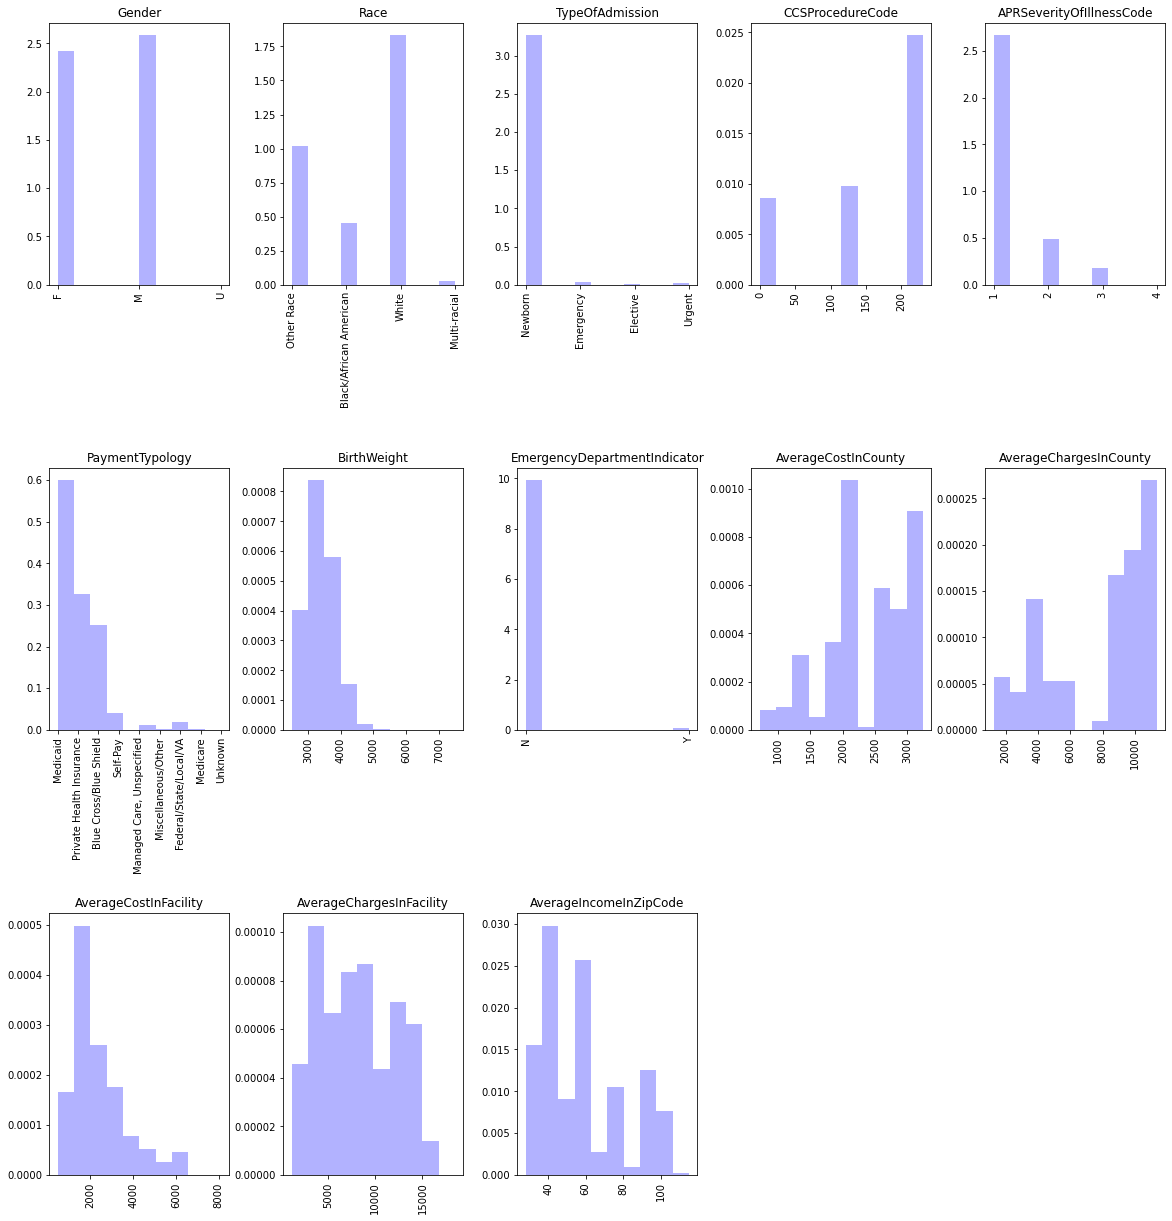

In [8]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X.columns):
    hist_plot(col, [patients_X[col]], ['b'], 3, 5, i+1)


###### 🧐 **Observations:**
> - Most categorical fields are not ordered. 
> - Categorical fields will need a numerical representation to be used in the ML model. 
> - Categorical fields will also need to be weighted correctly because using only a numeric placeholder for their string value will make higher numbers show more importance than lower numbers, warping the training and results.
> - For TypeOfAdmission, Emergency, Elective and Urgent are rare categories, most diabetes diagnosies are from Newborn. This means that diabetes diagnoses are found from genetic heritage, when tests are conducted on the newborns, rather than people being admitted to hospital from symptoms or sicknesses, that could have come from getting diabetes later in life.
> - Rare categories:
    - Unknown Gender
    - Severity of illness code 4
    - Yes Emergency Department Indicator
    - SelfPay PaymentTopology
    - Misc/Other PaymentTopology
    - Medicare PaymentTopology
    - Unknown PaymentTopology
    - Emergency TypeOfAdmission TODO FINISH THESE
###### 👨🏻‍🎓 Conclusions
| Column Name                  |      Data Type
|:------------------------------|:----------------------
| Gender                       |  Nominal Categorical
| Race                         |  Nominal Categorical
| TypeOfAdmission              |  Nominal Categorical
| CCSProcedureCode             |  Nominal Categorical
| APRSeverityOfIllnessCode     |  Ordinal Categorical
| PaymentTypology              |  Nominal Categorical
| BirthWeight                  |  Continuous Numerical
| EmergencyDepartmentIndicator |  Nominal Categorical
| AverageCostInCounty          |  Discrete Numerical
| AverageChargesInCounty       |  Discrete Numerical
| AverageCostInFacility        |  Discrete Numerical
| AverageChargesInFacility     |  Discrete Numerical
| AverageIncomeInZipCode       |  Discrete Numerical
| LengthOfStay (days)          |  Discrete Numerical
> - For the categorical fields to be weighted correctly, using one hot encoding to weight them by occurance will accurately share importance of the  fields to the target field.
> - Due to most diagnoses happening from Newborn tests from TypeOfAdmission, the EmergencyDepartmentIndicator shows correlation that most hospital admissions were not emergencies. It is hypothesised that the Emergency and Urgent category is related to the YES category in EmergencyDepartmentIndicator. One hot encoding and joining both urgent and emergency fields into a single field and comparing to YES field from EmergencyDepartmentIndicator, should be done to see if 

In [9]:
categorical_features = ['Gender','Race', 'TypeOfAdmission', 'CCSProcedureCode', 'APRSeverityOfIllnessCode', 'PaymentTypology', 'EmergencyDepartmentIndicator']
noncategorical_features = list(set(patients_X.columns).difference(set(categorical_features)))

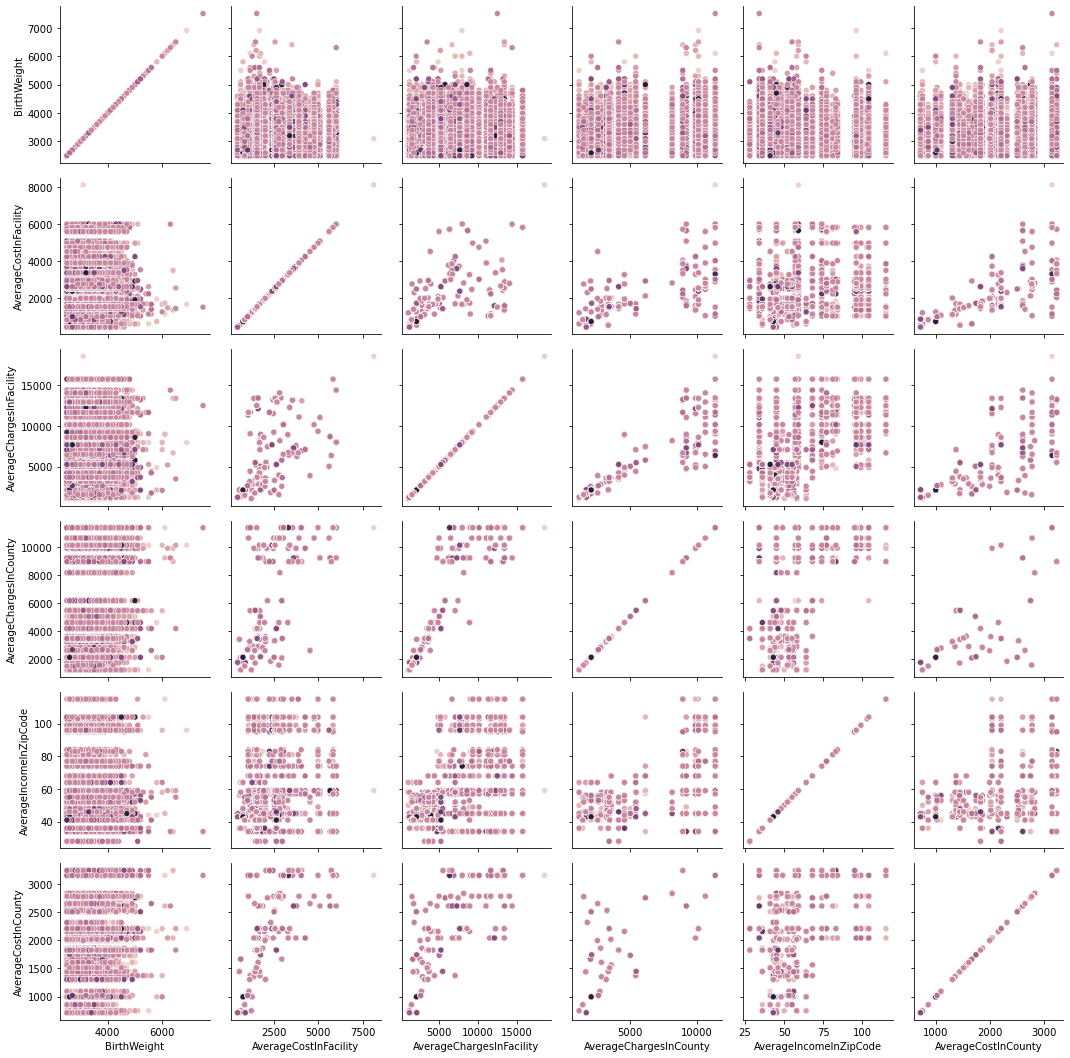

In [10]:
import seaborn as sns

g = sns.PairGrid(dataFrame, vars=noncategorical_features, hue="LengthOfStay")
g.map(sns.scatterplot)
plt.show()

#### Classifying the data into numerical values
None of the categorical fields were ordinal, and so the np.unique() function was only needed to transform.

In [11]:
# for i, col in enumerate(dataFrame.columns):
#     plt.boxplot(dataFrame[col])
#     plt.title('Median ' + col)
#     plt.show()

##### Splitting the dataset


In [ ]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# prepare cross validation
kfold = KFold(3, True, 1)
# enumerate splits
for train, test in kfold.split(data):
print('train: %s, test: %s' % (data[train], data[test]))

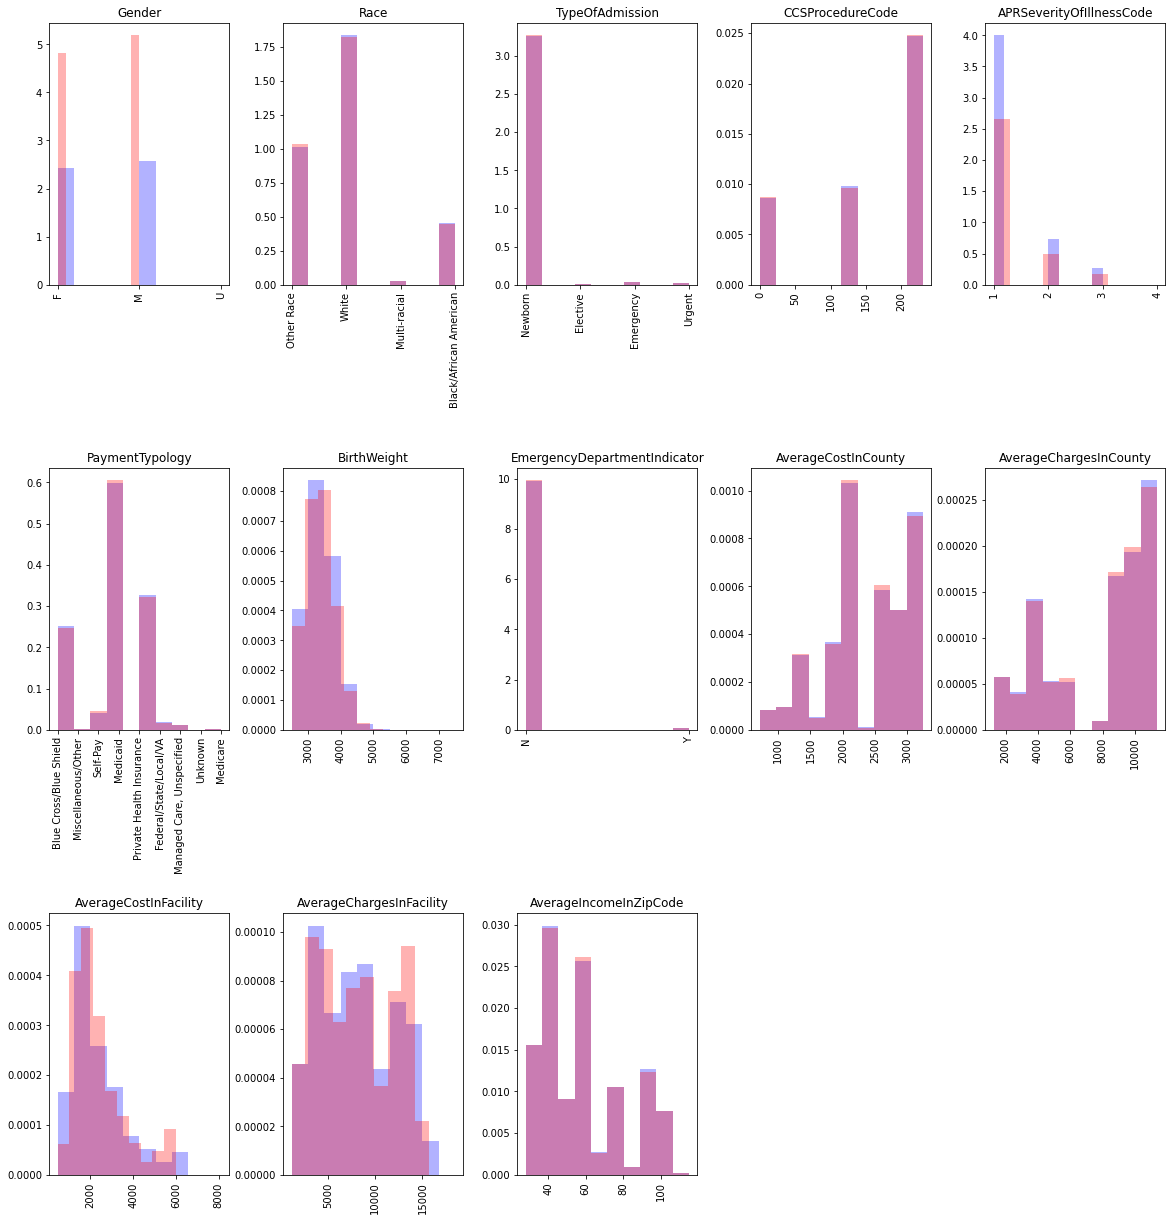

In [12]:
# Split the Data by 20%,
# TODO Why mode.chained_assignment?
# TODO Why 20%?
with pd.option_context('mode.chained_assignment', None):
    patients_X_train, patients_X_test, patients_y_train, patients_y_test = train_test_split(patients_X, patients_Y, test_size=0.2, shuffle=True)

# Show the training set and the test sets overlayed in histogram format.
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_X_train.columns):
    # 3 x 5 grid size, blue for training set, red for test set.
    hist_plot(col, [patients_X_train[col], patients_X_test[col]], ['b', 'r'], 3, 5, i+1)

> <span style="font-size:1em;">✔</span> **Observations:**
> - The data seems to be fairly evenly split.
> - <span style="font-size:1.5em;">⚠</span> Gender has different categories between it's train and test sets. Train has 2 categories, and Test has 3. This has occured from 1 of the categories containing an abnormally small number of results and during the splitting process, one set contains all of the results for that category. 

#### Correcting training and test sets.
It is important to characterize what are normal and abnormal observations in the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

patients_x_train_scaled = patients_X_train.copy()
patients_x_test_scaled = patients_X_test.copy()

# Scale continuous noncategorical features using minmax TODO Why Minmax scaler and not powerscaling?
minmaxscaler = MinMaxScaler().fit(patients_x_train_scaled.loc[:, noncategorical_features])
patients_x_train_scaled.loc[:, noncategorical_features] = minmaxscaler.transform(patients_x_train_scaled.loc[:, noncategorical_features])
patients_x_test_scaled.loc[:, noncategorical_features] = minmaxscaler.transform(patients_x_test_scaled.loc[:, noncategorical_features])

In [ ]:
# One-hot encode categorical features only
for column in categorical_features:
  hot_encoder = OneHotEncoder(handle_unknown='ignore')
  hot_encoder.fit(patients_x_train_scaled[[column]])
    
  # Encode the training set
  transformed_train_cols = hot_encoder.transform(patients_x_train_scaled[[column]]).toarray()
  for i in range(len(hot_encoder.categories_[0])):
    patients_x_train_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_train_cols[:,i]

  # Encode the testing set
  transformed_test_cols = hot_encoder.transform(patients_x_test_scaled[[column]]).toarray()
  for i in range(len(hot_encoder.categories_[0])):
    patients_x_test_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_test_cols[:,i]

In [ ]:
# Drop original columns because they are now represented in the dataframe by the new one hot encoded columns.
patients_x_train_scaled = patients_x_train_scaled.drop(categorical_features, axis=1)
patients_x_test_scaled = patients_x_test_scaled.drop(categorical_features, axis=1)

In [13]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_x_train_scaled.columns):
    hist_plot(col, [patients_x_train_scaled[col], patients_x_test_scaled[col]], ['b', 'r'], 7, 7, i+1)

In [ ]:
# One-hot encode categorical features only
for column in categorical_features:
  hot_encoder = OneHotEncoder(handle_unknown='ignore')
  hot_encoder.fit(patients_x_train_scaled[[column]])
    
  # Encode the training set
  transformed_train_cols = hot_encoder.transform(patients_x_train_scaled[[column]]).toarray()
  for i in range(len(hot_encoder.categories_[0])):
    patients_x_train_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_train_cols[:,i]

  # Encode the testing set
  transformed_test_cols = hot_encoder.transform(patients_x_test_scaled[[column]]).toarray()
  for i in range(len(hot_encoder.categories_[0])):
    patients_x_test_scaled[column + '_' + str(hot_encoder.categories_[0][i])] = transformed_test_cols[:,i]

In [ ]:
# Drop original columns because they are now represented in the dataframe by the new one hot encoded columns.
patients_x_train_scaled = patients_x_train_scaled.drop(categorical_features, axis=1)
patients_x_test_scaled = patients_x_test_scaled.drop(categorical_features, axis=1)

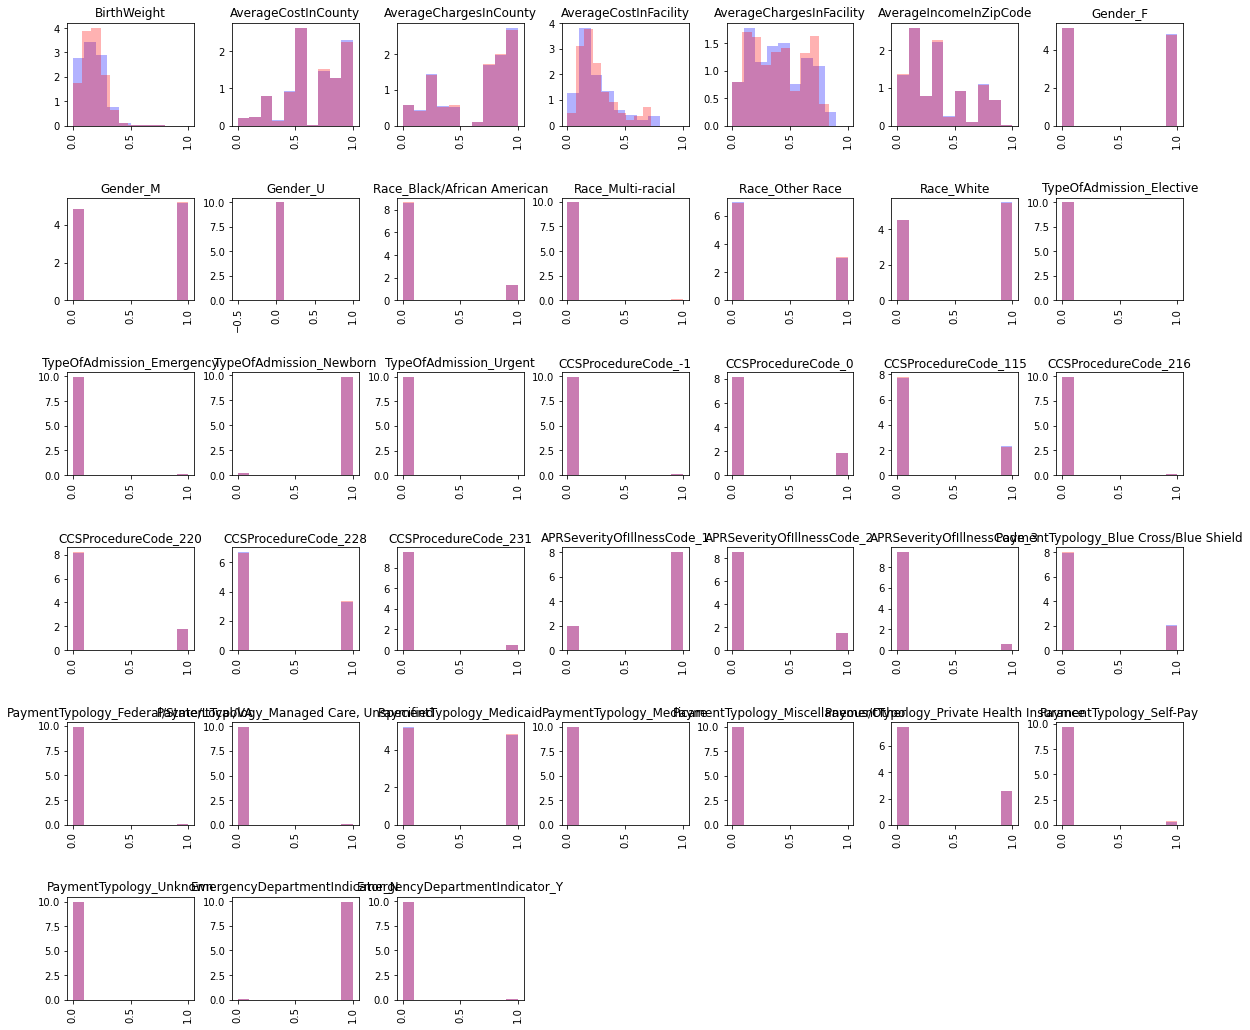

In [14]:
plt.figure(figsize=(20,20))
for i, col in enumerate(patients_x_train_scaled.columns):
    hist_plot(col, [patients_x_train_scaled[col], patients_x_test_scaled[col]], ['b', 'r'], 7, 7, i+1)

In [ ]:
import seaborn as sns

g = sns.PairGrid(patients_x_train_scaled, vars=patients_x_train_scaled.columns, hue="LengthOfStay")
g.map(sns.scatterplot)
plt.show()

KeyError: 'LengthOfStay'

In [ ]:
patients_x_test_scaled.head()

# Questions to Answer
What is the range of some of the attributes?
Which of the features have a very different average to the others?
Which feature is skewed (hint examine the histogram)?
Which features are highly correlated?

### Approach
##### Requirements & Restrictions for this project
To start off there were some requirements and restrictions for project:
xcv

##### Data Exploration
Ordinal categorical features
Nominal categorical features

Continuous Numerical features - Decimal
Discrete numerical features - Integers
##### Evaluation Framework

##### Methodology Selection

##### Hyper Parameter Selection Strategy
Random method, graph method, or the
##### Model Analyses


### Ultimate Judgment & Analysis

